In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from evaluation.prep_datasets import extract_features_not_normalised
from evaluation.evaluate_mimic import evaluate_mimic, evaluate_random
import torch

# Investigating ood performance
## Comparing ood performance of models to random guessing

In [2]:
# Load the models
num_features = 16

# for each file, load the model
models_random = []
with open('..\..\datasets\\1000random\\1000\\results_sidebysideLM\80\hyperparameters.pkl', 'rb') as f:
    hyperparameters = pkl.load(f)
    
    folder_path = '..\..\datasets\\1000random\\1000\\results_sidebysideLM\80\saved_models'
    for path in os.listdir(folder_path):
        if path.endswith('.pt'):
            with open(os.path.join(folder_path, path), 'rb') as f:
                model = torch.nn.Linear(num_features, 1)
                loaded_state_dict = torch.load(f)
                model.load_state_dict(loaded_state_dict)
                models_random.append(model)

models_mcts = []
with open('..\..\datasets\\1000mcts\\1000\\results_sidebysideLM\80\hyperparameters.pkl', 'rb') as f:
    hyperparameters = pkl.load(f)

    folder_path = '..\..\datasets\\1000mcts\\1000\\results_sidebysideLM\80\saved_models'
    for path in os.listdir(folder_path):
        if path.endswith('.pt'):
            with open(os.path.join(folder_path, path), 'rb') as f:
                model = torch.nn.Linear(num_features, 1)
                loaded_state_dict = torch.load(f)
                model.load_state_dict(loaded_state_dict)
                models_mcts.append(model)

models_step = []
with open('..\..\datasets\\1000step\\1000\\results_sidebysideLM\80\hyperparameters.pkl', 'rb') as f:
    hyperparameters = pkl.load(f)

    folder_path = '..\..\datasets\\1000step\\1000\\results_sidebysideLM\80\saved_models'
    for path in os.listdir(folder_path):
        if path.endswith('.pt'):
            with open(os.path.join(folder_path, path), 'rb') as f:
                model = torch.nn.Linear(num_features, 1)
                loaded_state_dict = torch.load(f)
                model.load_state_dict(loaded_state_dict)
                models_step.append(model)

FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\datasets\\1000random\\1000\\results_sidebysideLM\\80\\hyperparameters.pkl'

In [108]:
# Load the test set
with open('..\..\datasets\\100baseline\\100\cf_features.pkl', 'rb') as f:
    cf_features = torch.tensor(pkl.load(f))
with open('..\..\datasets\\100baseline\\100\org_features.pkl', 'rb') as f:
    org_features = torch.tensor(pkl.load(f))

train = torch.stack((org_features[:,:-1], cf_features[:,:-1]), dim=1).view(cf_features.shape[0], (cf_features.shape[1]-1)*2)
print(train.shape)
train_labels = org_features[:,-1] - cf_features[:,-1]

torch.Size([100, 16])


In [109]:
# Evaluate the models on ood data
test_losses_random, test_mean_errors_random, test_rmses_randmom, r2s_random, pearson_correlations_random, spearman_correlations_random = [], [], [], [], [], []
for model in models_random:
    test_loss, test_mean_error, test_rmse, r2, pearson_correlation, spearman_correlation, pred_label_pairs = evaluate_mimic(model, train, train_labels, worst=False, best=False, features=['citizens_saved', 'unsaved_citizens', 'distance_to_citizen', 'standing_on_extinguisher', 'length', 'could_have_saved', 'final_number_of_unsaved_citizens', 'moved_towards_closest_citizen'])
    test_losses_random.append(test_loss)
    test_mean_errors_random.append(test_mean_error)
    test_rmses_randmom.append(test_rmse)
    r2s_random.append(r2)
    pearson_correlations_random.append(pearson_correlation)
    spearman_correlations_random.append(spearman_correlation)

test_losses_mcts, test_mean_errors_mcts, test_rmses_mcts, r2s_mcts, pearson_correlations_mcts, spearman_correlations_mcts = [], [], [], [], [], []
for model in models_mcts:
    test_loss, test_mean_error, test_rmse, r2, pearson_correlation, spearman_correlation, pred_label_pairs = evaluate_mimic(model, train, train_labels, worst=False, best=False, features=['citizens_saved', 'unsaved_citizens', 'distance_to_citizen', 'standing_on_extinguisher', 'length', 'could_have_saved', 'final_number_of_unsaved_citizens', 'moved_towards_closest_citizen'])
    test_losses_mcts.append(test_loss)
    test_mean_errors_mcts.append(test_mean_error)
    test_rmses_mcts.append(test_rmse)
    r2s_mcts.append(r2)
    pearson_correlations_mcts.append(pearson_correlation)
    spearman_correlations_mcts.append(spearman_correlation)

test_losses_step, test_mean_errors_step, test_rmses_step, r2s_step, pearson_correlations_step, spearman_correlations_step = [], [], [], [], [], []
for model in models_step:
    test_loss, test_mean_error, test_rmse, r2, pearson_correlation, spearman_correlation, pred_label_pairs = evaluate_mimic(model, train, train_labels, worst=False, best=False, features=['citizens_saved', 'unsaved_citizens', 'distance_to_citizen', 'standing_on_extinguisher', 'length', 'could_have_saved', 'final_number_of_unsaved_citizens', 'moved_towards_closest_citizen'])
    test_losses_step.append(test_loss)
    test_mean_errors_step.append(test_mean_error)
    test_rmses_step.append(test_rmse)
    r2s_step.append(r2)
    pearson_correlations_step.append(pearson_correlation)
    spearman_correlations_step.append(spearman_correlation)

In [110]:
table1 = [
    ['measures'] + ['MCTS'] +  ['Step'] + ['Random'],
    ['loss'] + [round(np.mean(test_losses_mcts), 2)] + [round(np.mean(test_losses_step), 2)] + [round(np.mean(test_losses_random), 2)],
    ['mean error'] + [round(np.mean(test_mean_errors_mcts), 2)] + [round(np.mean(test_mean_errors_step), 2)] + [round(np.mean(test_mean_errors_random), 2)],
    ['rmse'] + [round(np.mean(test_rmses_mcts), 2)] + [round(np.mean(test_rmses_step), 2)] + [round(np.mean(test_rmses_randmom), 2)],
    ['r2'] + [round(np.mean(r2s_mcts), 2)] + [round(np.mean(r2s_step), 2)] + [round(np.mean(r2s_random), 2)],
    ['pearson'] + [round(np.mean(pearson_correlations_mcts), 2)] + [round(np.mean(pearson_correlations_step), 2)] + [round(np.mean(pearson_correlations_random), 2)],
    ['spearman'] + [round(np.mean(spearman_correlations_mcts), 2)] + [round(np.mean(spearman_correlations_step), 2)] + [round(np.mean(spearman_correlations_random), 2)]
]

print(tabulate(table1, headers='firstrow'))
print(tabulate(table1, headers='firstrow', tablefmt='latex'))

measures      MCTS    Step    Random
----------  ------  ------  --------
loss         16.35    2.89      2.18
mean error    3.33    1.28      1
rmse          4.04    1.7       1.48
r2           -5.83   -0.21      0.09
pearson       0.27    0.31      0.46
spearman      0.27    0.23      0.47
\begin{tabular}{lrrr}
\hline
 measures   &   MCTS &   Step &   Random \\
\hline
 loss       &  16.35 &   2.89 &     2.18 \\
 mean error &   3.33 &   1.28 &     1    \\
 rmse       &   4.04 &   1.7  &     1.48 \\
 r2         &  -5.83 &  -0.21 &     0.09 \\
 pearson    &   0.27 &   0.31 &     0.46 \\
 spearman   &   0.27 &   0.23 &     0.47 \\
\hline
\end{tabular}


MCTS does really badly on the error measures, but decent on the correlations. This might mean it picks up something, but the skew in average values pushes the error metrics to be bad

In [39]:
class GaussianDistributionSampler:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def sample(self, size=1):
        return np.random.normal(self.mean, self.std, size)

In [40]:
# Evaluate random predictions
mcts_distribution_sampler = GaussianDistributionSampler(0.8, 2.18)
test_loss_mcts_random, test_mean_error_mcts_random, test_rmse_mcts_random, r2_mcts_random, pearson_correlation_mcts_random, spearman_correlation_mcts_random, pred_label_pairs_mcts_random = evaluate_random(mcts_distribution_sampler, train, train_labels)

random_distribution_sampler = GaussianDistributionSampler(-0.28, 1.99)
test_loss_random_random, test_mean_error_random_random, test_rmse_random_random, r2_random_random, pearson_correlation_random_random, spearman_correlation_random_random, pred_label_pairs_random_random = evaluate_random(random_distribution_sampler, train, train_labels)

step_distribution_sampler = GaussianDistributionSampler(1.93, 2.86)
test_loss_step_random, test_mean_error_step_random, test_rmse_step_random, r2_step_random, pearson_correlation_step_random, spearman_correlation_step_random, pred_label_pairs_step_random = evaluate_random(step_distribution_sampler, train, train_labels)



In [41]:
table2 = [
    ['measures'] + ['MCTS(random)'] + ['Random(random)'] + ['Step(random)'],
    ['loss'] + [round(test_loss_mcts_random,2)] + [round(test_loss_random_random,2)] + [round(test_loss_step_random,2)],
    ['mean error'] + [round(test_mean_error_mcts_random,2)] + [round(test_mean_error_random_random,2)] + [round(test_mean_error_step_random,2)],
    ['rmse'] + [round(test_rmse_mcts_random,2)] + [round(test_rmse_random_random,2)] + [round(test_rmse_step_random,2)],
    ['r2'] + [round(r2_mcts_random,2)] + [round(r2_random_random,2)] + [round(r2_step_random,2)],
    ['pearson'] + [round(pearson_correlation_mcts_random,2)] + [round(pearson_correlation_random_random,2)] + [round(pearson_correlation_step_random,2)],
    ['spearman'] + [round(spearman_correlation_mcts_random,2)] + [round(spearman_correlation_random_random,2)] + [round(spearman_correlation_step_random,2)]
]
print(tabulate(table2, headers='firstrow'))

measures      MCTS(random)    Random(random)    Step(random)
----------  --------------  ----------------  --------------
loss                  6.28              7.2            11.1
mean error            2                 2.05            2.59
rmse                  2.51              2.68            3.33
r2                   -1.78             -2.19           -3.92
pearson               0.15             -0.05            0.11
spearman              0.17             -0.01            0.24


In [20]:
combined_table = []
for row1, row2 in zip(table1, table2):
    combined_table.append(row1 + row2[1:])  # skip the 'measures' column from second table
headers = ["measures", "MCTS", "Random", "Step", "MCTS(random)", "Random(random)", "Step(random)"]
print(tabulate(combined_table, headers=headers))

measures    MCTS    Random    Step    MCTS(random)    Random(random)    Step(random)
----------  ------  --------  ------  --------------  ----------------  --------------
measures    MCTS    Random    Step    MCTS(random)    Random(random)    Step(random)
loss        2.96    1.54      17.57   6.69            6.73              15.12
mean error  1.32    0.89      3.15    1.92            2.07              3.04
rmse        1.72    1.24      4.09    2.59            2.59              3.89
r2          -0.31   0.32      -6.78   -1.96           -1.98             -5.7
pearson     0.29    0.62      0.12    0.08            -0.07             -0.01
spearman    0.25    0.47      0.15    0.17            -0.12             -0.1


### Interpretation

Given that the datasets the models were trained on significantly bias it in a certain direction (e.g. labels for step are much more negative than labels in the ood dataset) I wanted to find out how much information is actually contained in their predictions. To do so I compared them to a model which uniformly samples predictions from the range of labels in their training dataset.

I found that esp MCTS and random perform significantly better than simply randomly sampling from their training distribution. That implies that they did learn some real structure about what causes the rewards. 
However, step barely performs better than it's random counterpart. This is worrying, because one would hope that it can outperform


### Why does this happen?

This could be caused by using different model architectures. E.g. a larger NN is more prone to overfitting on the training data and might perform less well on data from a different training distribution.

Maybe the metrics are not as sensitive to the differences in quality of predictions that are in a small range far away from the actual label. E.g. predicting -2.9 instead of -3.1, when the correct answer was +0.2. This would make step look comparatively worse

## Showing the distribution of predictions

In [111]:
# Get predictions on the ood dataset

preds_step = []
for model in models_step:
    y_pred = model(train).squeeze()
    preds_step.append(y_pred)

preds_mcts = []
for model in models_mcts:
    y_pred = model(train).squeeze()
    preds_mcts.append(y_pred)

preds_random = []
for model in models_random:
    y_pred = model(train).squeeze()
    preds_random.append(y_pred)

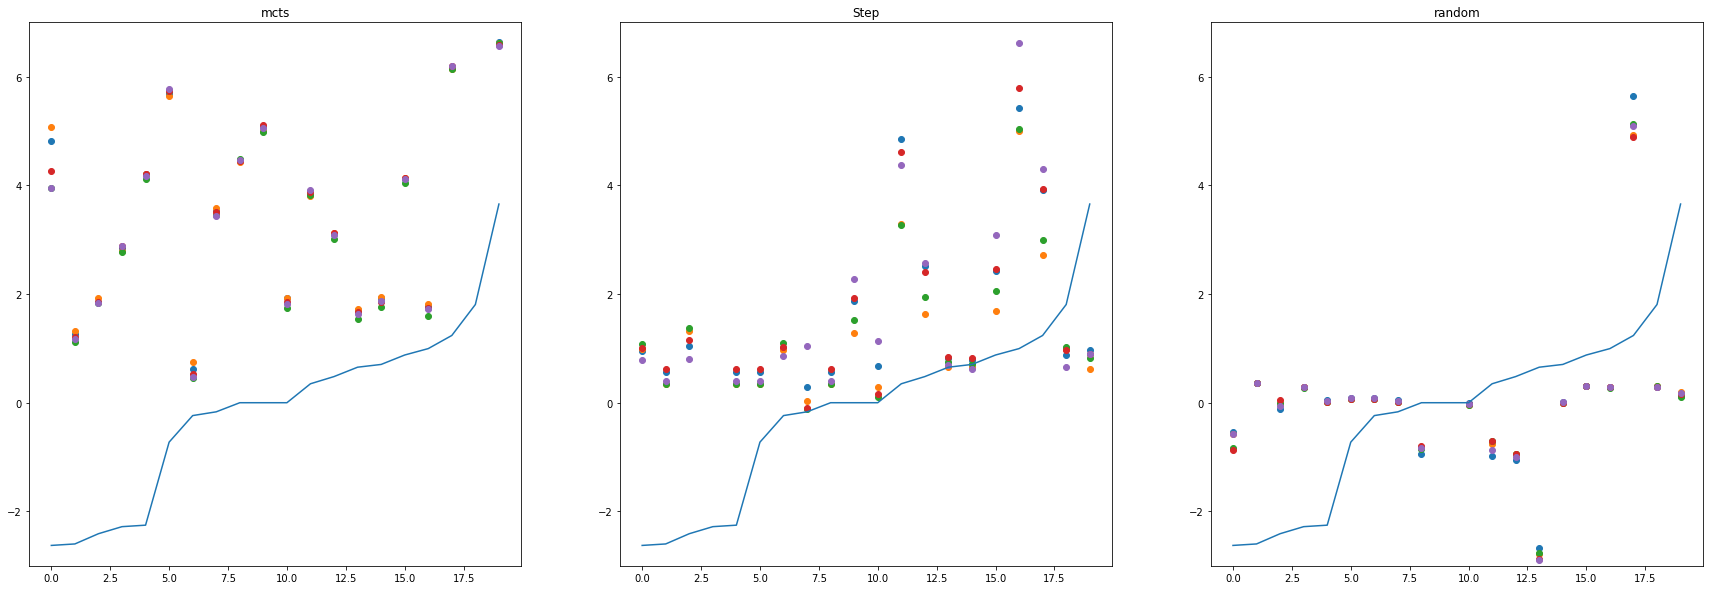

In [126]:
# visualize the predictions of different models
plt.figure(figsize=(30,10))
x = np.arange(0, 20)

paired_lists = [list(zip(pred, train_labels[:20])) for pred in preds_step]
sorted_pairs = [sorted(item, key=lambda x: x[1]) for item in paired_lists]
sorted_preds_step = [[item[0].detach().numpy() for item in pair_list] for pair_list in sorted_pairs]

plt.subplot(1,3,2)
plt.ylim(-3, 7)
plt.scatter(x, sorted_preds_step[0], label='step')
plt.scatter(x, sorted_preds_step[1][:20], label='step')
plt.scatter(x, sorted_preds_step[2][:20], label='step')
plt.scatter(x, sorted_preds_step[3][:20], label='step')
plt.scatter(x, sorted_preds_step[4][:20], label='step')
plt.plot(x, sorted(train_labels[:20].detach().numpy()), label='actual')
plt.title('Step')

paired_lists = [list(zip(pred, train_labels[:20])) for pred in preds_mcts]
sorted_pairs = [sorted(item, key=lambda x: x[1]) for item in paired_lists]
sorted_preds_mcts = [[item[0].detach().numpy() for item in pair_list] for pair_list in sorted_pairs]

plt.subplot(1,3,1)
plt.ylim(-3, 7)
plt.scatter(x, sorted_preds_mcts[0], label='mcts')
plt.scatter(x, sorted_preds_mcts[1][:20], label='mcts')
plt.scatter(x, sorted_preds_mcts[2][:20], label='mcts')
plt.scatter(x, sorted_preds_mcts[3][:20], label='mcts')
plt.scatter(x, sorted_preds_mcts[4][:20], label='mcts')
plt.plot(x, sorted(train_labels[:20].detach().numpy()), label='actual')
plt.title('mcts')

paired_lists = [list(zip(pred, train_labels[:20])) for pred in preds_random]
sorted_pairs = [sorted(item, key=lambda x: x[1]) for item in paired_lists]
sorted_preds_random = [[item[0].detach().numpy() for item in pair_list] for pair_list in sorted_pairs]

plt.subplot(1,3,3)
plt.ylim(-3, 7)
plt.scatter(x, sorted_preds_random[0], label='random')
plt.scatter(x, sorted_preds_random[1][:20], label='random')
plt.scatter(x, sorted_preds_random[2][:20], label='random')
plt.scatter(x, sorted_preds_random[3][:20], label='random')
plt.scatter(x, sorted_preds_random[4][:20], label='random')
plt.plot(x, sorted(train_labels[:20].detach().numpy()), label='actual')
plt.title('random')


plt.show()



In [113]:
# Average and std of predictions compared to true labels
# take the mean of preds_step which is a list of tensors
preds_step_stack = torch.stack(preds_step)
mean_pred_step = torch.mean(preds_step_stack).detach().numpy().item()
std_pred_step = torch.std(preds_step_stack).detach().numpy().item()
preds_mcts_stack = torch.stack(preds_mcts)
mean_pred_mcts = torch.mean(preds_mcts_stack).detach().numpy().item()
std_pred_mcts = torch.std(preds_mcts_stack).detach().numpy().item()
preds_random_stack = torch.stack(preds_random)
mean_pred_random = torch.mean(preds_random_stack).detach().numpy().item()
std_pred_random = torch.std(preds_random_stack).detach().numpy().item()
mean_label = torch.mean(train_labels).detach().numpy().item()
std_label = torch.std(train_labels).detach().numpy().item()

table = [
    [''] + ['MCTS'] + ['Random'] + ['Step'] + ['Label'],
    ['mean'] + [round(mean_pred_mcts,2)] + [round(mean_pred_random,2)] + [round(mean_pred_step,2)] + [round(mean_label,2)],
    ['std'] + [round(std_pred_mcts,2)] + [round(std_pred_random,2)] + [round(std_pred_step,2)] + [round(std_label,2)]
]
print(tabulate(table, headers='firstrow'))

        MCTS    Random    Step    Label
----  ------  --------  ------  -------
mean    2.92     -0.05    0.58    -0.05
std     2.72      1.23    1.05     1.56


### Observations

The predictions of the step-models are distributed wider than those of mcts. The predictions of the step-models go surprisingly high. I would have expected them to be lower than the actual labels, because the model has mostly seen lower labels in training.

The average guess of MCTS is much closer to the average of true labels than the average of step is.

MCTS has a much smaller variance in predictions compare to the true labels. This means it does not match the higher or lower values, but mostly sticks around the average. MCTS models are also more similar to each other compared to step models who vary more in their predictions.

The different random models make extremely similar predictions to each other. This makes sense, because models trained on the same distribution will have more similar guesses on that distribution than outside that distribution.

### Interpretation

It would be interesting to compare how the models behave on their own data.

It again shows that step generalises much worse. However, surprisingly it shows that mcts and step predict values that are too high, despite the labels in their training data being lower.

Questions:
- What in the data of these models makes them generalise in a certain way?
- Why does MCTS data lead to models that are more similar to each other on ood data?

## Comparing predictions on own test set and ood test set

In [116]:
# load the data sets of mcts, step and random
with open('..\..\datasets\\100mcts\\100\\results_sidebysideLM\80\data_split.pkl', 'rb') as f:
    train_mcts, train_labels_mcts, test_mcts, test_labels_mcts = pkl.load(f)

with open('..\..\datasets\\100step\\100\\results_sidebysideLM\80\data_split.pkl', 'rb') as f:
    train_step, train_labels_step, test_step, test_labels_step = pkl.load(f)

with open('..\..\datasets\\100random\\100\\results_sidebysideLM\80\data_split.pkl', 'rb') as f:
    train_random, train_labels_random, test_random, test_labels_random = pkl.load(f)

In [127]:
# print the minimum and maximum label for the train_labels
print('mcts', torch.min(train_labels_mcts), torch.max(train_labels_mcts))
print('step', torch.min(train_labels_step), torch.max(train_labels_step))
print('random', torch.min(train_labels_random), torch.max(train_labels_random))

mcts tensor(-3.6403) tensor(15.4917)
step tensor(-6.7999) tensor(8.6247)
random tensor(-3.7159) tensor(7.0670)


In [117]:
# Make predictions on those datasets
preds_step = []
for model in models_step:
    y_pred = model(test_step).squeeze()
    preds_step.append(y_pred)

preds_mcts = []
for model in models_mcts:
    y_pred = model(test_mcts).squeeze()
    preds_mcts.append(y_pred)

preds_random = []
for model in models_random:
    y_pred = model(test_random).squeeze()
    preds_random.append(y_pred)

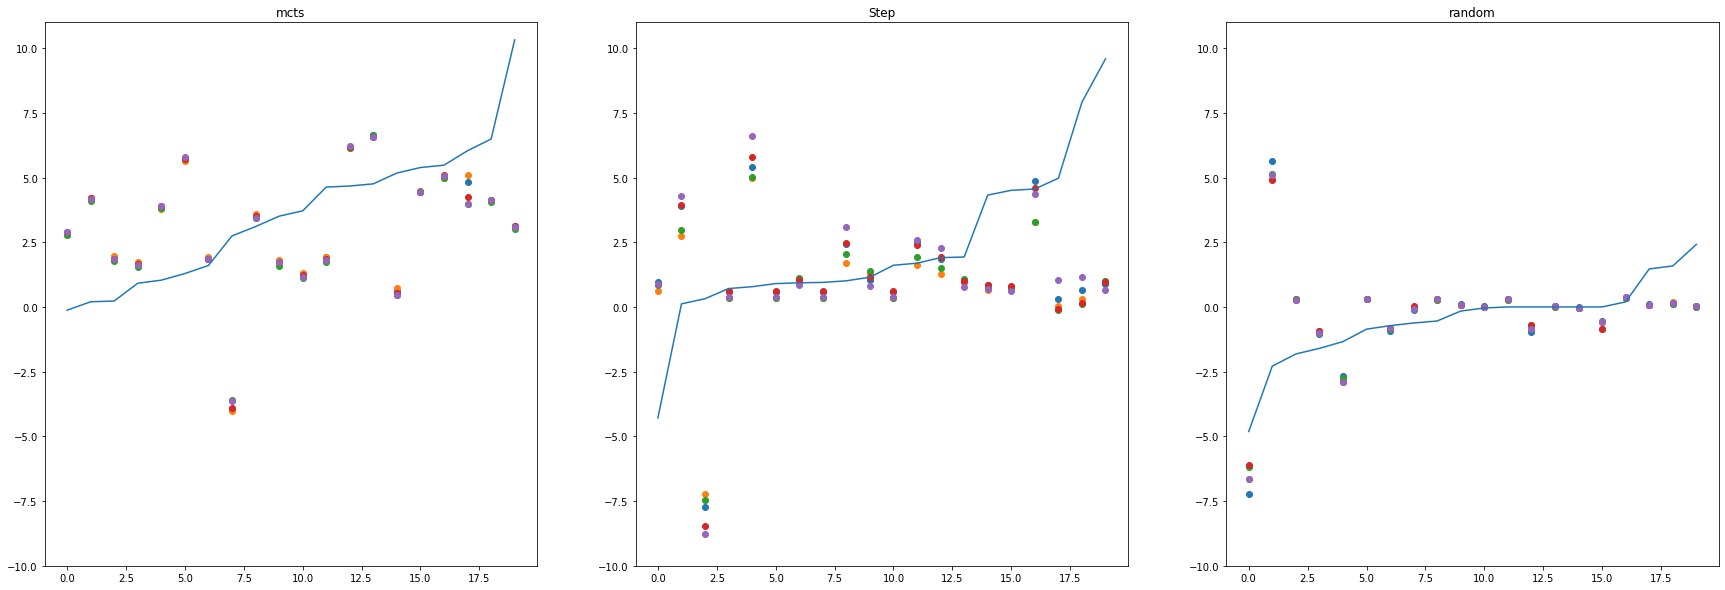

In [124]:
# visualize the predictions of different models
plt.figure(figsize=(30,10))
x = np.arange(0, len(test_labels_step))

paired_lists = [list(zip(pred, train_labels_step)) for pred in preds_step]
sorted_pairs = [sorted(item, key=lambda x: x[1]) for item in paired_lists]
sorted_preds_step = [[item[0].detach().numpy() for item in pair_list] for pair_list in sorted_pairs]

plt.subplot(1,3,2)
plt.ylim(-10,11)
plt.scatter(x, sorted_preds_step[0], label='step')
plt.scatter(x, sorted_preds_step[1], label='step')
plt.scatter(x, sorted_preds_step[2], label='step')
plt.scatter(x, sorted_preds_step[3], label='step')
plt.scatter(x, sorted_preds_step[4], label='step')
plt.plot(x, sorted(test_labels_step.detach().numpy()), label='actual')
plt.title('Step')

paired_lists = [list(zip(pred, train_labels_mcts)) for pred in preds_mcts]
sorted_pairs = [sorted(item, key=lambda x: x[1]) for item in paired_lists]
sorted_preds_mcts = [[item[0].detach().numpy() for item in pair_list] for pair_list in sorted_pairs]

plt.subplot(1,3,1)
plt.ylim(-10,11)
plt.scatter(x, sorted_preds_mcts[0], label='mcts')
plt.scatter(x, sorted_preds_mcts[1], label='mcts')
plt.scatter(x, sorted_preds_mcts[2], label='mcts')
plt.scatter(x, sorted_preds_mcts[3], label='mcts')
plt.scatter(x, sorted_preds_mcts[4], label='mcts')
plt.plot(x, sorted(test_labels_mcts.detach().numpy()), label='actual')
plt.title('mcts')

paired_lists = [list(zip(pred, train_labels_random)) for pred in preds_random]
sorted_pairs = [sorted(item, key=lambda x: x[1]) for item in paired_lists]
sorted_preds_random = [[item[0].detach().numpy() for item in pair_list] for pair_list in sorted_pairs]

plt.subplot(1,3,3)
plt.ylim(-10,11)
plt.scatter(x, sorted_preds_random[0], label='random')
plt.scatter(x, sorted_preds_random[1], label='random')
plt.scatter(x, sorted_preds_random[2], label='random')
plt.scatter(x, sorted_preds_random[3], label='random')
plt.scatter(x, sorted_preds_random[4], label='random')
plt.plot(x, sorted(test_labels_random.detach().numpy()), label='actual')
plt.title('random')


plt.show()



In [122]:
# Average and std of predictions compared to true labels
# take the mean of preds_step which is a list of tensors
preds_step_stack = torch.stack(preds_step)
mean_pred_step = torch.mean(preds_step_stack).detach().numpy().item()
std_pred_step = torch.std(preds_step_stack).detach().numpy().item()
preds_mcts_stack = torch.stack(preds_mcts)
mean_pred_mcts = torch.mean(preds_mcts_stack).detach().numpy().item()
std_pred_mcts = torch.std(preds_mcts_stack).detach().numpy().item()
preds_random_stack = torch.stack(preds_random)
mean_pred_random = torch.mean(preds_random_stack).detach().numpy().item()
std_pred_random = torch.std(preds_random_stack).detach().numpy().item()
mean_label_step = torch.mean(train_labels_step).detach().numpy().item()
std_label_step = torch.std(train_labels_step).detach().numpy().item()
mean_label_mcts = torch.mean(train_labels_mcts).detach().numpy().item()
std_label_mcts = torch.std(train_labels_mcts).detach().numpy().item()
mean_label_random = torch.mean(train_labels_random).detach().numpy().item()
std_label_random = torch.std(train_labels_random).detach().numpy().item()

table = [
    [''] + ['MCTS'] + ['Random'] + ['Step'],
    ['mean pred'] + [round(mean_pred_mcts,2)] + [round(mean_pred_random,2)] + [round(mean_pred_step,2)],
    ['std pred'] + [round(std_pred_mcts,2)] + [round(std_pred_random,2)] + [round(std_pred_step,2)],
    ['mean label'] + [round(mean_label_mcts,2)] + [round(mean_label_random,2)] + [round(mean_label_step,2)],
    ['std label'] + [round(std_label_mcts,2)] + [round(std_label_random,2)] + [round(std_label_step,2)]
]
print(tabulate(table, headers='firstrow'))

              MCTS    Random    Step
----------  ------  --------  ------
mean pred     3.04     -0.28    1
std pred      2.29      2.14    2.6
mean label    2.8       0.01    0.9
std label     3.26      1.5     2.63


### Observations

**MCTS**: The predictions are not as widely distributed as the labels. Also compare

**Step**: One would think that step data is harder to predict, because the labels have a larger variance. But they end up having lower mean error than MCTS or random

In [68]:
# Evaluate the models
test_losses_random, test_mean_errors_random, test_rmses_randmom, r2s_random, pearson_correlations_random, spearman_correlations_random = [], [], [], [], [], []
for model in models_random:
    test_loss, test_mean_error, test_rmse, r2, pearson_correlation, spearman_correlation, pred_label_pairs = evaluate_mimic(model, train_random, train_labels_random, worst=False, best=False, features=['citizens_saved', 'unsaved_citizens', 'distance_to_citizen', 'standing_on_extinguisher', 'length', 'could_have_saved', 'final_number_of_unsaved_citizens', 'moved_towards_closest_citizen'])
    test_losses_random.append(test_loss)
    test_mean_errors_random.append(test_mean_error)
    test_rmses_randmom.append(test_rmse)
    r2s_random.append(r2)
    pearson_correlations_random.append(pearson_correlation)
    spearman_correlations_random.append(spearman_correlation)

test_losses_mcts, test_mean_errors_mcts, test_rmses_mcts, r2s_mcts, pearson_correlations_mcts, spearman_correlations_mcts = [], [], [], [], [], []
for model in models_mcts:
    test_loss, test_mean_error, test_rmse, r2, pearson_correlation, spearman_correlation, pred_label_pairs = evaluate_mimic(model, train_mcts, train_labels_mcts, worst=False, best=False, features=['citizens_saved', 'unsaved_citizens', 'distance_to_citizen', 'standing_on_extinguisher', 'length', 'could_have_saved', 'final_number_of_unsaved_citizens', 'moved_towards_closest_citizen'])
    test_losses_mcts.append(test_loss)
    test_mean_errors_mcts.append(test_mean_error)
    test_rmses_mcts.append(test_rmse)
    r2s_mcts.append(r2)
    pearson_correlations_mcts.append(pearson_correlation)
    spearman_correlations_mcts.append(spearman_correlation)

test_losses_step, test_mean_errors_step, test_rmses_step, r2s_step, pearson_correlations_step, spearman_correlations_step = [], [], [], [], [], []
for model in models_step:
    test_loss, test_mean_error, test_rmse, r2, pearson_correlation, spearman_correlation, pred_label_pairs = evaluate_mimic(model, train_step, train_labels_step, worst=False, best=False, features=['citizens_saved', 'unsaved_citizens', 'distance_to_citizen', 'standing_on_extinguisher', 'length', 'could_have_saved', 'final_number_of_unsaved_citizens', 'moved_towards_closest_citizen'])
    test_losses_step.append(test_loss)
    test_mean_errors_step.append(test_mean_error)
    test_rmses_step.append(test_rmse)
    r2s_step.append(r2)
    pearson_correlations_step.append(pearson_correlation)
    spearman_correlations_step.append(spearman_correlation)

In [69]:
table1 = [
    ['measures'] + ['MCTS'] +  ['Step'] + ['Random'],
    ['loss'] + [round(np.mean(test_losses_mcts), 2)] + [round(np.mean(test_losses_step), 2)] + [round(np.mean(test_losses_random), 2)],
    ['mean error'] + [round(np.mean(test_mean_errors_mcts), 2)] + [round(np.mean(test_mean_errors_step), 2)] + [round(np.mean(test_mean_errors_random), 2)],
    ['rmse'] + [round(np.mean(test_rmses_mcts), 2)] + [round(np.mean(test_rmses_step), 2)] + [round(np.mean(test_rmses_randmom), 2)],
    ['r2'] + [round(np.mean(r2s_mcts), 2)] + [round(np.mean(r2s_step), 2)] + [round(np.mean(r2s_random), 2)],
    ['pearson'] + [round(np.mean(pearson_correlations_mcts), 2)] + [round(np.mean(pearson_correlations_step), 2)] + [round(np.mean(pearson_correlations_random), 2)],
    ['spearman'] + [round(np.mean(spearman_correlations_mcts), 2)] + [round(np.mean(spearman_correlations_step), 2)] + [round(np.mean(spearman_correlations_random), 2)]
]

print(tabulate(table1, headers='firstrow'))
print(tabulate(table1, headers='firstrow', tablefmt='latex'))

measures      MCTS    Step    Random
----------  ------  ------  --------
loss          3.78    0.89      1.54
mean error    1.44    0.52      0.89
rmse          1.92    0.94      1.24
r2            0.61    0.88      0.32
pearson       0.78    0.94      0.62
spearman      0.77    0.79      0.47
\begin{tabular}{lrrr}
\hline
 measures   &   MCTS &   Step &   Random \\
\hline
 loss       &   3.78 &   0.89 &     1.54 \\
 mean error &   1.44 &   0.52 &     0.89 \\
 rmse       &   1.92 &   0.94 &     1.24 \\
 r2         &   0.61 &   0.88 &     0.32 \\
 pearson    &   0.78 &   0.94 &     0.62 \\
 spearman   &   0.77 &   0.79 &     0.47 \\
\hline
\end{tabular}
